# Problem Set 5
## 14.382 - Econometrics
_Mohit Karnani_

### 1 The Bootstrap
The nonparametric Bootstrap method consists on resampling our sample (with replacement) and recomputing our estimate of interest multiple times to later approximate its variance. The nonparametric Bootstrap relies on the Borel-Cantelli lemma, which indicates that, when the sample size is large enough, the sample dgp aproaches the population dgp. In some intuitive sense, we resample over the available data because its the best knowledge that we have about the actual underlying dgp, so we think of the sample distribution as if it were the population distribution and draw (bootstrap) subsamples out of it.

Notwithstanding, this idea is not enough for having a valid Bootstrap estimator. The validity relies in two key characteristics: (approximate) linearity and normality. For example, the classic Bootstrap does not work when we want to estimate the distribution of the maximum of a uniformly distributed variable, because the maximum is a nonlinear operator.

Given the latter, as both the sample mean and the GMM estimator satisfy with (approximate) linearity and normality, the nonparametric Bootsrap can be used to make inference.

### 2 Simultaneous inference by bootstrapping

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils import resample
from scipy.stats import norm

#### (a)
The estimated model here is $$inuidur1_i=\beta_0+\sum_{j=1}^5 1[tg_i==j]\beta_j+\underbrace{XB}_{controls}+\varepsilon_i.$$
The treatment effects are reported below.

In [26]:
df = pd.read_csv('C:/Users/mohit/Dropbox (MIT)/s2019/14.382/ps5/penn_jae.csv')
df.loc[df.tg == 6, 'tg'] = 4
df = pd.concat([df.iloc[:, 1], pd.get_dummies(df['tg']), df.iloc[:, 2:]], axis = 1)
ols = LinearRegression()
ols.fit(df.iloc[:, 2:], df.inuidur1)
beta = ols.coef_[:5]
print('The treatment effects are', beta)

The treatment effects are [-0.49053993 -0.59754744 -0.32677576 -0.78589913 -0.20796179]


#### (b)
Here I bootstrapped the estimated coefficients to construct the confidence bands. I first computed the estimated standard errors and then obtained the critical values of the empirical t-statistics.
For the individual confidence bands, I estimated individual critical values such that 5% of the (module of the) bootstrapped t-statistics would surpass their corresponding critical values.
For the joint confidence bands, I estimated a single critical value such that 5% of the (module of the) bootstrapped t-statistics would surpass this unique critical value.
Then I just defined the confidence bands as $[\beta_j-c_jse_j,\beta_j+c_jse_j], \forall j\in\{1,2,3,4,5\}$.

In [3]:
B = 10000
alpha = 0.05
betas = np.empty([B, np.size(beta)])
for b in range(B):
    bsample = resample(df, replace = True, random_state = b)
    ols.fit(bsample.iloc[:, 2:], bsample.inuidur1)
    betas[b, :] = ols.coef_[:5]
se = np.sqrt(np.sum(np.square(betas - beta) / B, 0))
c1 = np.percentile(abs((betas - beta) / se), 100 * (1 - alpha), axis = 0)
print('The individual CIs are \n', np.append([beta - c1 * se], [beta + c1 * se], axis = 0).T)
c2 = np.percentile(np.max(abs((betas - beta) / se), 1), 100 * (1 - alpha))
print('The joint CIs are \n', np.append([beta - c2 * se], [beta + c2 * se], axis = 0).T)

The individual CIs are 
 [[-1.14957285  0.16849299]
 [-1.14219545 -0.05289943]
 [-0.92325784  0.26970632]
 [-1.29888468 -0.27291358]
 [-0.81178687  0.39586329]]
The joint CIs are 
 [[-1.33761552  0.35653565]
 [-1.30718803  0.11209316]
 [-1.10307755  0.44952604]
 [-1.45114954 -0.12064872]
 [-0.99181983  0.57589625]]


#### (c)
As we would expect, the individual critical values are close to the asympototic approximation. Nevertheless, the joint critical value is higher. This makes sense, as we are now letting 5% of _all_ bootstrapped t-statistics surpass this value. Thus, the joint confidence bands are wider than the individual ones (just as in the lecture notes).

In [4]:
print('The individual critical values are', c1,
      'the joint critical value is', c2,
      'and the asymptotic critical value is', norm.ppf(1 - alpha / 2))

The individual critical values are [1.97267173 1.94602023 1.94821413 1.95519402 1.95318605] the joint critical value is 2.5355365727453907 and the asymptotic critical value is 1.959963984540054


### 3 Counterfactual distribution regressions

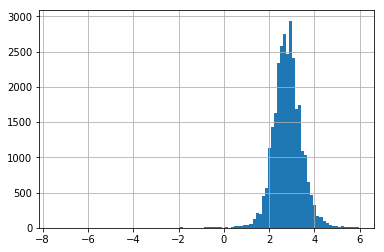

In [5]:
df = pd.read_csv('C:/Users/mohit/Dropbox (MIT)/s2019/14.382/ps5/cps2012.csv').iloc[:, 1:]
df['lnw'].hist(bins = 100)
gridsize=100
T = np.linspace(np.percentile(df['lnw'], 0.5), np.percentile(df['lnw'], 99.5), gridsize)
dfw = df.loc[df.female == 1, :]
dfm = df.loc[df.female == 0, :]

#### (a)
We already know that distribution regressions can be considered as multiple maximum-likelihood estimations. Nevertheless, we can formulated this as a GMM problem by stacking the parameter vector $b(y)$ corresponding to each cutoff $y\in T$ to form a new, single (long) vector of parameters $\theta$.
Then, the moment condition is simply a stacked version of the FOCs that would arise in the multiple ML estimations. Explicitly, $$m_i(W_i,\theta)=\left(\frac{\partial \left[1[Y_i\leq y]\ln\Lambda(Xb(y))+1[Y_i> y]\ln(1-\Lambda(Xb(y)))\right]}{\partial b(y)}\right)_{y\in T}$$

#### (b)
The results are below.

In [6]:
F = np.empty([3, gridsize])
logit = LogisticRegression(C = 1000000)
for y in range(gridsize):
    logit.fit(dfw.iloc[:, 2:-1], dfw.lnw < T[y], dfw.weight)
    F[0, y] = np.sum(logit.predict_proba(dfw.iloc[:, 2:-1])[:, 1]) / len(dfw.index)
    logit.fit(dfm.iloc[:, 2:-1], dfm.lnw < T[y], dfm.weight)
    F[1, y] = np.sum(logit.predict_proba(dfm.iloc[:, 2:-1])[:, 1]) / len(dfm.index)
    F[2, y] = np.sum(logit.predict_proba(dfw.iloc[:, 2:-1])[:, 1]) / len(dfw.index)

Text(0,0.5,'Cummulative Probability')

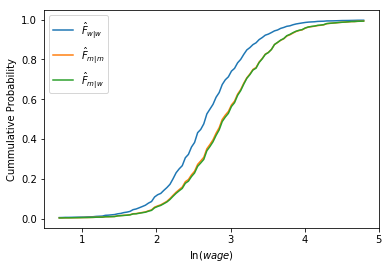

In [7]:
plt.plot(T, F[0, :],
         T, F[1, :],
         T, F[2, :])
plt.legend([r'$\hat{F}_{w|w}$', r'$\hat{F}_{m|m}$', r'$\hat{F}_{m|w}$'])
plt.xlabel(r'$\ln(wage)$')
plt.ylabel(r'Cummulative Probability')

In [8]:
B = 200
alpha = 0.05
Fs = np.empty([3, gridsize, B])
for b in range(B):
    bsamplew = resample(dfw, replace = True, random_state = b)
    bsamplem = resample(dfm, replace = True, random_state = b)
    for y in range(gridsize):
        logit.fit(bsamplew.iloc[:, 2:-1], bsamplew.lnw < T[y], bsamplew.weight)
        Fs[0, y, b] = np.sum(logit.predict_proba(bsamplew.iloc[:, 2:-1])[:, 1]) / len(bsamplew.index)
        logit.fit(bsamplem.iloc[:, 2:-1], bsamplem.lnw < T[y], bsamplem.weight)
        Fs[1, y, b] = np.sum(logit.predict_proba(bsamplem.iloc[:, 2:-1])[:, 1]) / len(bsamplem.index)
        Fs[2, y, b] = np.sum(logit.predict_proba(bsamplew.iloc[:, 2:-1])[:, 1]) / len(bsamplew.index)

array([[[0.00415887, 0.00490383, 0.00579223, ..., 0.00471642,
         0.00439919, 0.00491106],
        [0.00457904, 0.00504196, 0.00619169, ..., 0.00506331,
         0.00485635, 0.00499715],
        [0.00555737, 0.005804  , 0.00698586, ..., 0.00543461,
         0.00516539, 0.00537253],
        ...,
        [0.99759262, 0.99631696, 0.9964193 , ..., 0.9977325 ,
         0.99639177, 0.9975704 ],
        [0.99786726, 0.99631696, 0.9965086 , ..., 0.9977325 ,
         0.99639177, 0.99765462],
        [0.99786726, 0.99631696, 0.9965086 , ..., 0.9977325 ,
         0.99639177, 0.99765462]],

       [[0.00352614, 0.00383958, 0.00336393, ..., 0.00474648,
         0.00371315, 0.0042444 ],
        [0.00362099, 0.00410805, 0.00346295, ..., 0.00489717,
         0.00380677, 0.0044779 ],
        [0.00375783, 0.00432999, 0.0036291 , ..., 0.00494121,
         0.00393789, 0.00455725],
        ...,
        [0.99238186, 0.99210486, 0.9909963 , ..., 0.99281379,
         0.99181134, 0.99193367],
        [0.9

In [9]:
se0 = np.sqrt(np.sum(np.square(Fs[0, :, :] - F[0].reshape(gridsize, 1)) / B, 1))
c0 = np.percentile(np.max(abs((Fs[0, :, :] - F[0].reshape(gridsize, 1)) / se0.reshape(gridsize, 1)), 0), 100 * (1 - alpha))
se1 = np.sqrt(np.sum(np.square(Fs[1, :, :] - F[1].reshape(gridsize, 1)) / B, 1))
c1 = np.percentile(np.max(abs((Fs[1, :, :] - F[1].reshape(gridsize, 1)) / se1.reshape(gridsize, 1)), 0), 100 * (1 - alpha))
se2 = np.sqrt(np.sum(np.square(Fs[2, :, :] - F[2].reshape(gridsize, 1)) / B, 1))
c2 = np.percentile(np.max(abs((Fs[2, :, :] - F[2].reshape(gridsize, 1)) / se2.reshape(gridsize, 1)), 0), 100 * (1 - alpha))

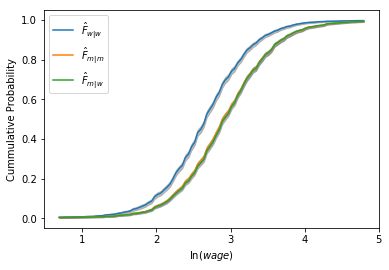

In [10]:
plt.plot(T, F[0, :],
         T, F[1, :],
         T, F[2, :])
plt.legend([r'$\hat{F}_{w|w}$', r'$\hat{F}_{m|m}$', r'$\hat{F}_{m|w}$'])
plt.xlabel(r'$\ln(wage)$')
plt.ylabel(r'Cummulative Probability')
plt.fill_between(T, F[0, :] - c0 * se0, F[0, :] + c0 * se0, color = 'grey', alpha = '0.5')
plt.fill_between(T, F[1, :] - c1 * se1, F[1, :] + c1 * se1, color = 'grey', alpha = '0.5')
plt.fill_between(T, F[2, :] - c2 * se2, F[2, :] + c2 * se2, color = 'grey', alpha = '0.5')

#### (c)
The results are below.

I also included the smooth quantile functions (direct inverses, without grid-swich error).


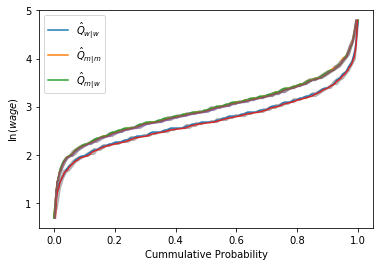

In [11]:
u = np.linspace(0, 1, gridsize)
Q = np.empty([3, gridsize])
Qu = np.empty([3, gridsize])
Ql = np.empty([3, gridsize])
for i in range(gridsize - 1):
    Q[:, i] = T[np.max(np.cumsum(F < u[i], axis = 1), axis = 1)]
    #These bands are just fast approximations. A more correct (and slow) way of obtaining these is by bootstrapping again.
    Qu[:, i] = T[np.max(np.cumsum(F - np.array([c0 * se0, c1 * se1, c2 * se2]) < u[i], axis = 1), axis = 1)]
    Ql[:, i] = T[np.max(np.cumsum(F + np.array([c0 * se0, c1 * se1, c2 * se2]) < u[i], axis = 1), axis = 1)]
Q[:,gridsize - 1] = np.max(T)
Qu[:,gridsize - 1] = np.max(T)
Ql[:,gridsize - 1] = np.max(T)
plt.plot(u, Q[0, :],
         u, Q[1, :],
         u, Q[2, :])
plt.legend([r'$\hat{Q}_{w|w}$', r'$\hat{Q}_{m|m}$', r'$\hat{Q}_{m|w}$'])
plt.ylabel(r'$\ln(wage)$')
plt.xlabel(r'Cummulative Probability')
plt.fill_between(u, Ql[0, :], Qu[0, :], color = 'grey', alpha = '0.5')
plt.fill_between(u, Ql[1, :], Qu[1, :], color = 'grey', alpha = '0.5')
plt.fill_between(u, Ql[2, :], Qu[2, :], color = 'grey', alpha = '0.5')
plt.plot(F[0, :], T, F[1, :], T, F[2, :], T)
print('In case the grid size is small, I also included the smooth quantile functions (direct inverses, without grid-swich error).')

#### (d)
We can clearly observe that the discrimination part is more important. This is precisely what we expected, as it is similar to what we saw in the lecture notes. Indeed, in this sample we can see that females have about the same average observables as males, but with slightly higher averages in college and advanced degrees. Therefore, we should expect the compositional component to be close to zero, or even slightly negative, which is what we obtain below.

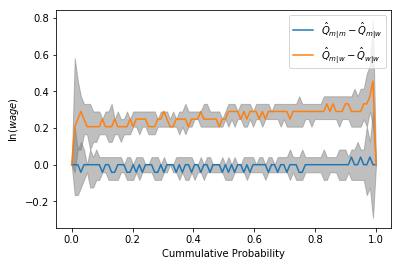

In [24]:
Comp, Disc = Q[1] - Q[2], Q[2] - Q[0]
Compl, Discl = Ql[1] - Qu[2], Ql[2] - Qu[0]
Compu, Discu = Qu[1] - Ql[2], Qu[2] - Ql[0]
plt.plot(u, Comp,
         u, Disc)
plt.legend([r'$\hat{Q}_{m|m}-\hat{Q}_{m|w}$', r'$\hat{Q}_{m|w}-\hat{Q}_{w|w}$'])
plt.ylabel(r'$\ln(wage)$')
plt.xlabel(r'Cummulative Probability')
plt.fill_between(u, Compl, Compu, color = 'grey', alpha = '0.5')
plt.fill_between(u, Discl, Discu, color = 'grey', alpha = '0.5')

#### (e)
I would expect the approaches to differ (as we saw in 14.662). We know that $$\underbrace{\hat{Q}_{m|m}-\hat{Q}_{m|w}}_{composition}+\underbrace{\hat{Q}_{m|w}-\hat{Q}_{w|w}}_{discrimination}=-[\underbrace{\hat{Q}_{w|m}-\hat{Q}_{m|m}}_{discrimination}+\underbrace{\hat{Q}_{w|w}-\hat{Q}_{w|m}}_{composition}],$$ but in this case, the order matters.

Indeed, we will now be calculating a decomposition in which the 'zero' we add is $\hat{Q}_{w|m}$ instead of $\hat{Q}_{m|w}$. This can yield really different outcomes (DiNardo, Fortin and Firpo, 2010, NBER WP). Mathematically, we will now estimate the logit model using females in the sample and then compute the predicted values with males, which is the opposite to what we did in this exercise.